In [1]:
import os
import glob
from natsort import natsorted
from tqdm import tqdm
import itertools

import pandas as pd
import numpy as np

from nilearn import image

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

from scipy.stats import pearsonr, zscore, ttest_1samp
from statsmodels.stats.multitest import fdrcorrection

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_ROIactivation(path, beta_map):
    #activity in ROI
    mask = image.load_img(path)
    mask = np.array(mask.dataobj, dtype='bool').flatten()
    roi_activation = beta_map[mask, :]

    #Remove nan values (these are voxels that do not vary across the different videos)
    inds = ~np.any(np.isnan(roi_activation), axis=1)
    roi_activation = roi_activation[inds, ...]
    return roi_activation.mean(axis=0)

In [3]:
def regression(X_train_, y_train_, X_test_, features): 
    #Standardize X
    scaler = StandardScaler()
    X_train_ = scaler.fit_transform(X_train_)

    #Ridge CV to get the alpha parameter
    clf = RidgeCV(cv=4).fit(X_train_, y_train_)

    #Fit the Ridge model with the found best alpha
    lr = Ridge(fit_intercept=False, alpha=clf.alpha_).fit(X_train_, y_train_)

    #Scale testing 
    mean = scaler.mean_[:X_test_.shape[1]]
    var = scaler.var_[:X_test_.shape[1]]
    X_test_ = (X_test_ - mean)/var
    
    y_pred = np.zeros((len(features), X_test.shape[0]))
    for ifeature, feature in enumerate(features):
        y_pred[ifeature, :] = X_test_[:, ifeature] * lr.coef_[ifeature]
    return y_pred

In [4]:
def explained_variance_score(y_true, y_pred):
    rho, _ = pearsonr(y_true, y_pred)
    return rho

In [5]:
def permutation_test(y_pred, y_true, test_inds, n_perm=int(5e3), H0='greater'): 
    r_true = explained_variance_score(y_pred, y_true)
    r_null = np.zeros(n_perm)
    for i in range(n_perm):
        inds = np.random.default_rng(i).permutation(test_inds.shape[0])
        inds = test_inds[inds, :].flatten()
        y_true_shuffle = y_true[inds]
        r_null[i] = explained_variance_score(y_true_shuffle, y_pred)
    if H0 == 'two_tailed':
        p = np.sum(np.abs(r_null) >= np.abs(r_true)) / n_perm
    elif H0 == 'greater':
        p = 1 - (np.sum(r_true >= r_null) / n_perm)
    return r_true, p, r_null

In [6]:
def bootstrap(y_pred, y_true, test_inds, n_samples=int(5e3)):
    r_var = np.zeros(n_samples)
    for i in range(n_samples):
        inds = np.random.default_rng(i).choice(np.arange(test_inds.shape[0]), size=test_inds.shape[0])
        inds = test_inds[inds, :].flatten()
        r_var[i] = explained_variance_score(y_true[inds], y_pred[inds])
    return r_var

In [7]:
def plot_ROI_results(df, outname, variable):
    features = df.Features.unique()
    n_features = len(features)
    roi = df.ROIs.unique()[0]

    #Set up figures
    sns.set(style='whitegrid', context='talk', rc={'figure.figsize':(6,5)})
    fig, ax = plt.subplots()

    colors = ['#48D4E1', '#8C55FD', '#FADC00']
    cmap = sns.color_palette(colors, as_cmap=True)
    g = sns.barplot(x='Features', y=variable,
                    data=df, ax=ax,
                    hue='Feature category',
                    palette=cmap,
                    dodge=False, ci=None)

    #Plot noise ceiling
    x = np.linspace(0, n_features, num=3)
    y1 = np.ones_like(x)*noise_ceiling.loc[noise_ceiling.ROIs == roi, variable].tolist()[0]
    ax.plot(x, y1, color='gray', alpha=0.5, linewidth=3)
    
    for ifeature, feature in enumerate(df.Features.unique()):
        x = ifeature
        sig = df.loc[df.Features == feature, 'group sig'].reset_index(drop=True)[0]
        p = df.loc[df.Features == feature, 'group_pcorrected'].reset_index(drop=True)[0]
        if sig:
            if p > 0.01:
                text = '*'
            elif p < 0.01 and p > 0.001:
                text = '**'
            elif p < 0.001:
                text = '***'
            ax.annotate(text, (x, 0.5), fontsize=20,
                        weight='bold', ha='center', color='gray')
            
        y1 = df[(df.Features == feature)].mean()['low sem']
        y2 = df[(df.Features == feature)].mean()['high sem']
        plt.plot([x, x], [y1, y2], 'black', linewidth=2)

    # #Aesthetics
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
    ax.set_xlabel('')
    ax.set_ylabel('Prediction accuracy ($\it{r}$)')
#     ax.tick_params(axis='y', labelsize=12)
    ax.set_ylim([-0.38, 0.58])
    sns.despine(left=True)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend([],[], frameon=False)
    plt.tight_layout()
    if outname is not None:
        plt.savefig(outname)
        plt.close()
    else:
        plt.title(roi)

In [8]:
top_dir = '/Users/emcmaho7/Dropbox/projects/SI_fmri/fmri'
data_dir = f'{top_dir}/input_data'
out_dir = f'{top_dir}/output_data'
figure_dir = f'{top_dir}/figures'

In [9]:
rois = ['EVC', 'MT', 'EBA', 'PPA', 'TOS', 'RSC', 'LOC',  'FFA', 'OFA', '-STS', 'biomotion', 'SIpSTS', 'TPJ', 'DMPFC']
roi_names = ['EVC', 'MT', 'EBA', 'PPA', 'OPA', 'RSC', 'LOC',  'FFA', 'OFA', 'faceSTS', 'biomotion', 'SIpSTS', 'TPJ', 'DMPFC']

## Loading

In [10]:
control_model = np.load(f'{out_dir}/generate_models/control_model.npy')
X = np.load(f'{out_dir}/generate_models/annotated_model.npy')

# Get the feature names for the annotated model
feature_categories = ['visual', 'visual', 'visual', 'visual', 'visual',
             'social detection', 'social detection', 
             'social evaluation', 'social evaluation', 'social evaluation', 'social evaluation', 'social evaluation']
features = pd.read_csv(f'{data_dir}/annotations/annotations.csv').columns.to_list()
features.remove('video_name')

In [11]:
n_subjs = 4
beta_maps = []
for sid_ in range(n_subjs):
    sid = str(sid_+1).zfill(2)
    beta_maps.append(np.load(f'{out_dir}/grouped_runs/sub-{sid}/sub-{sid}_train-data.npy'))
beta_maps = np.array(beta_maps)

In [12]:
noise_ceiling = pd.read_csv(f'{out_dir}/reliability/noise_ceiling.csv')
noise_ceiling = noise_ceiling.groupby('ROIs').mean().reset_index()

In [13]:
variable='Pearson r'
df = pd.DataFrame()

n_splits = 10
n_conditions = 200
n_condpersplit = int(n_conditions/n_splits)
n_features = len(features)
kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)

#Save the rs and null distributions
null_samples = int(5e3)
rs = np.zeros((n_subjs, len(rois), len(features)))
rs_null = np.zeros((n_subjs, len(rois), len(features), null_samples))
rs_var = np.zeros_like(rs_null)
for sid_ in range(n_subjs): 
    sid = str(sid_+1).zfill(2)
    for iroi, (roi, roi_name) in enumerate(zip(rois, roi_names)):
        y = get_ROIactivation(glob.glob(f'{data_dir}/ROI_masks/sub-{sid}/*{roi}*nii.gz')[0], beta_maps[sid_, ...])

        #Iterate through the different splits
        y_pred = np.zeros((n_features, n_condpersplit, n_splits))
        y_true = np.zeros((n_condpersplit, n_splits))
        test_inds = np.zeros((n_condpersplit, n_splits), dtype='int')
        for i, (train_index, test_index) in enumerate(kf.split(X)):
            #Split the training and test data
#             X_train, X_test = X_new[train_index], X_new[test_index]
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            #save the current indices
            test_inds[:, i] = test_index
            y_true[:, i] = y_test
            
            #new X - combine the annotated features with the nuissance regressors
            X_train = np.append(X_train, control_model[train_index], axis=1)
        
            #Prediction
            y_pred[:, :, i] = regression(X_train, y_train, X_test, features)

        #Evaluation & Save to data frame
        for ifeature, (feature, category) in enumerate(zip(features, feature_categories)):
#         for ifeature, feature in enumerate(pcs):
            r, p, r_null = permutation_test(y_pred[ifeature, :, :].flatten(),
                                       y_true.flatten(), test_inds, n_perm=null_samples)
            r_var = bootstrap(y_pred[ifeature, :, :].flatten(),
                              y_true.flatten(), test_inds, n_samples=null_samples)
            df = df.append({'Subjects': f'sub-{sid}',
                            'Features': feature,
                            'Feature category': category,
                            'ROIs': roi_name, 
                            'Pearson r': r,
                            'p value': p, 
                            'low sem': r-r_var.std(), 
                            'high sem': r+r_var.std(), 
                            'Explained variance': r ** 2},
                            ignore_index=True)
            rs[sid_, iroi, ifeature] = r
            rs_null[sid_, iroi, ifeature, :] = r_null
            rs_var[sid_, iroi, ifeature, :] = r_var

## Group p values

In [14]:
df['subj sig'] = df['p value'] < 0.05

In [15]:
df['group_p_value'] = 0 

rs_avg = rs.mean(axis=0)
rs_avg_null = rs_null.mean(axis=0)
ps = np.zeros_like(rs_avg)
for iroi, roi in enumerate(roi_names):
     for ifeature, feature in enumerate(features):
            p = np.sum(np.abs(rs_avg_null[iroi, ifeature, :]) >= np.abs(rs_avg[iroi, ifeature])) / null_samples
            ps[iroi, ifeature] = p
            df.loc[(df.ROIs == roi) & (df.Features == feature), 'group_p_value'] = p

In [16]:
df['group_pcorrected'] = 0 
ps_corrected = np.zeros_like(ps)
for iroi, roi in enumerate(roi_names):
    bools, ps_corrected[iroi, :] =  fdrcorrection(ps[iroi, :], alpha=0.05)
    for ifeature, feature in enumerate(features):
        df.loc[(df.ROIs == roi) & (df.Features == feature), 'group_pcorrected'] = ps_corrected[iroi, ifeature]
df['group sig'] = df['group_pcorrected'] < 0.05

In [17]:
df.to_csv(f'{out_dir}/roi_encoding/encoding_models.csv', index=False)

## Plotting

In [18]:
for roi in roi_names:
    plot_ROI_results(df[df.ROIs == roi], f'{figure_dir}/roi_encoding/{roi}.pdf', variable)

# EVC Control Model

## Run regression

In [19]:
def regression_evc(X_train, y_train, X_test): 
    #Standardize X
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)

    #Ridge CV to get the alpha parameter
    clf = RidgeCV(cv=4).fit(X_train, y_train)

    #Fit the Ridge model with the found best alpha
    lr = Ridge(fit_intercept=False, alpha=clf.alpha_).fit(X_train, y_train)

    #Scale testing 
    X_test = scaler.transform(X_test)
    return X_test @ lr.coef_

In [20]:
rois = ['EVC', 'MT']
roi_names = ['EVC', 'MT']
variable='Pearson r'
df = pd.DataFrame()

kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
#Save the rs and null distributions
rs = np.zeros((n_subjs, len(rois)))
rs_null = np.zeros((n_subjs, len(rois), int(5e3)))
rs_var = np.zeros_like(rs_null)
for sid_ in range(n_subjs): 
    sid = str(sid_+1).zfill(2)
    for iroi, (roi, roi_name) in enumerate(zip(rois, roi_names)):
        y = get_ROIactivation(glob.glob(f'{data_dir}/ROI_masks/sub-{sid}/*region-{roi}*nii.gz')[0], beta_maps[sid_, ...])

        #Iterate through the different splits
        y_pred = np.zeros((n_condpersplit, n_splits))
        y_true = np.zeros((n_condpersplit, n_splits))
        test_inds = np.zeros((n_condpersplit, n_splits), dtype='int')
        for i, (train_index, test_index) in enumerate(kf.split(X)):
            #Split the training and test data
            X_train, X_test = control_model[train_index], control_model[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            #save the current indices
            test_inds[:, i] = test_index
            y_true[:, i] = y_test
        
            #Prediction
            y_pred[:, i] = regression_evc(X_train, y_train, X_test)
        
        r, p, r_null = permutation_test(y_pred.flatten(),
                                   y_true.flatten(), test_inds)
        r_var = bootstrap(y_pred.flatten(),
                          y_true.flatten(), test_inds)
        df = df.append({'Subjects': f'sub-{sid}',
                        'Features': 'control model',
                        'ROIs': roi_name, 
                        'Pearson r': r,
                        'p value': p, 
                        'low sem': r-r_var.std(), 
                        'high sem': r+r_var.std(), 
                        'Explained variance': r ** 2},
                        ignore_index=True)
        rs[sid_, iroi] = r
        rs_null[sid_, iroi, :] = r_null
        rs_var[sid_, iroi, :] = r_var

## Group p values

In [21]:
df['subj sig'] = df['p value'] < 0.05

In [22]:
df['group_p_value'] = 0 

rs_avg = rs.mean(axis=0)
rs_avg_null = rs_null.mean(axis=0)
ps = np.zeros_like(rs_avg)
for iroi, roi in enumerate(roi_names):
    p = np.sum(np.abs(rs_avg_null[iroi, :]) >= np.abs(rs_avg[iroi])) / 5e3
    ps[iroi] = p
    df.loc[(df.ROIs == roi), 'group_p_value'] = p
df['group sig'] = df['group_p_value'] < 0.05

In [23]:
df.to_csv(f'{out_dir}/roi_encoding/control_model_prediction.csv', index=False)

## Plotting

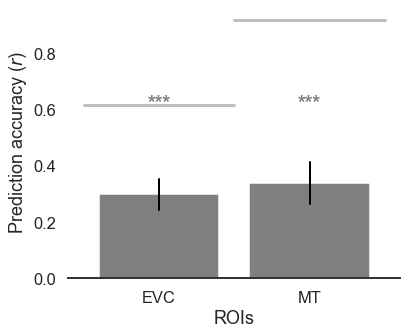

In [25]:
fig, ax = plt.subplots()
sns.set(style='white', context='talk')
sns.barplot(x='ROIs', y='Pearson r',
           data=df, ax=ax, 
           color='gray', ci=None)

for iroi, roi in enumerate(df.ROIs.unique()):
    x = iroi
    sig = df.loc[df.ROIs == roi, 'group sig'].reset_index(drop=True)[0]
    p = df.loc[df.ROIs == roi, 'group_p_value'].reset_index(drop=True)[0]
    if sig:
        if p > 0.01:
            text = '*'
        elif p < 0.01 and p > 0.001:
            text = '**'
        elif p < 0.001:
            text = '***'
        ax.annotate(text, (x, 0.6), fontsize=20,
                    weight='bold', ha='center', color='gray')
    
    #Plot error bars
    y1 = df[(df.ROIs == roi)].mean()['low sem']
    y2 = df[(df.ROIs == roi)].mean()['high sem']
    plt.plot([x, x], [y1, y2], 'black', linewidth=2)
    
    #Plot noise ceiling
    x = np.linspace(x-0.5, x+0.5, num=3)
    y1 = np.ones_like(x)*noise_ceiling.loc[noise_ceiling.ROIs == roi, variable].tolist()[0]
    ax.plot(x, y1, color='gray', alpha=0.5, linewidth=3)

ax.set_ylabel('Prediction accuracy ($\it{r}$)')
sns.despine(left=True)
# ax.set_ylim([0, 0.65])
plt.tight_layout()
plt.savefig(f'{figure_dir}/roi_encoding/control_model.pdf')